In [27]:
from rl4co.envs import landuseOptEnv
import torch
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.models.nn.env_embeddings.context import LOPContext
from rl4co.models.nn.env_embeddings.dynamic import StaticEmbedding
from rl4co.models.nn.env_embeddings.init import lopInitEmbedding
from rl4co.envs.urbanplan.cityplan import init
import torch
from tensordict.tensordict import TensorDict

In [28]:
''' neighbour to list '''
polygoncount = 221
neighbourlist = init.getneighbourlist('../Data/queen.csv', polygoncount)
basiclanduse = init.readlanduselist('../Data/baseParcels.shp', polygoncount)
landusePalette = {'Commercial': 'coral',
                  'Residential': 'peachpuff',
                  'Office': 'indianred',
                  'Residential&Commercial': 'lightsalmon',
                  'Green Space': 'lightgreen',
                  'Education': 'lightskyblue',
                  'Hospital': 'royalblue',
                  'SOHO': 'lightcoral'
                  }

landtype = ['Commercial', 'Residential', 'Office', 'Residential&Commercial', 'Green Space', 'Education', 'Hospital',
            'SOHO']
adj_matrix = init.get_adjacency_matrix('../Data/queen.csv', polygoncount)
import math
import numpy as np
shapefile = '../Data/Parcels.shp'


arealist = init.readarealist(shapefile, polygoncount)
locs_list = init.normalizeloc(shapefile)
locs = torch.tensor(locs_list, dtype=torch.float32).unsqueeze(0)
areas = torch.tensor(init.normalizearea(arealist), dtype=torch.float32).unsqueeze(0)
init_plan = torch.tensor(init.map_to_num(basiclanduse, landtype), dtype=torch.int64).unsqueeze(0)
fixed_mask = torch.ones_like(init_plan, dtype=torch.bool)
fixed_mask[(init_plan == 4) | (init_plan == 6)] = 0
neighbourlist = torch.tensor(adj_matrix).unsqueeze(0)
distances = torch.tensor(init.calculate_distance_matrix(locs_list), dtype=torch.float32).unsqueeze(0)
td = TensorDict(
    {
        "locs": locs,
        "areas": areas,
        "init_plan": init_plan,
        "fixed_mask": fixed_mask,
        "adjacency_list": neighbourlist,
        "distances": distances,
    },
    batch_size=1,
)

In [29]:
batch_size = 1024
env = landuseOptEnv(generator_params=dict(num_loc=50))
emb_dim = 128
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=lopInitEmbedding(emb_dim),
                              context_embedding=LOPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)
# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       baseline='rollout',
                       policy=policy,
                       )

tensor(1.5303) 7.911144353029169 -1.7283626685098388
Time: 3.653977155685425
Tour lengths: ['-1.53']


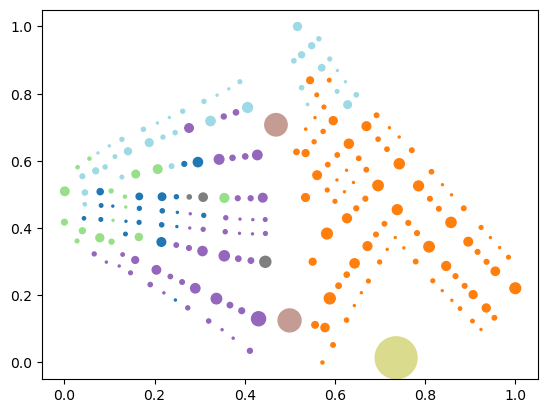

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = landuseOptEnv(generator_params=dict(num_loc=221)).to(device)
new_model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints100/epoch_epoch=000.ckpt", strict=False, load_baseline=False)
policy_new = new_model_checkpoint.policy.to(device)
#env = new_model_checkpoint.env.to(device)
td_init = env.reset(td = td, batch_size=[1]).to(device)
# print(td_init[0])
# print(td_init[0].get("locs"))
# print(td_init[0].get("areas"))
# print(td_init[0].get("init_plan"))
# print(td_init[0].get("adjacency_list"))
# print(td_init[0].get("distances").tolist())
# print(init.map_to_strings(td_init[0].get("init_plan").tolist(), landtype))
import time
start_time = time.time() 
out = policy_new(td_init.clone(), env, phase="test", decode_type="sampling", return_actions=True)
end_time = time.time()  # 获取函数运行后的时间（秒）
elapsed_time = end_time - start_time  # 计算运行时间
print(f"Time: {elapsed_time}")
# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)